### Brain Age Prediction using Ridge Regression, Gaussian Process Regression, Support Vector Regression 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plotnine import * 
import pandas as pd
import pickle
import time

from sklearn import preprocessing
# from time import time
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load data
dat = np.load('./full_reduced/full/feaDAT.npy')
age = np.load('./full_reduced/full/ageDAT.npy')
sex = np.load('./full_reduced/full/sexDAT.npy')

In [18]:
X = preprocessing.scale(dat)

# Split into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, age, test_size = 0.2, random_state = 42)


In [19]:
X.shape

(2026, 5124)

### Ridge regression

In [6]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [7]:
alphas = np.logspace(-6, 6, 200)
# reg = RidgeCV(alphas, cv=3)
reg = RidgeCV(alphas) # LOO CV
reg.fit(X_train, y_train) 

Y_pred = reg.predict(X_test)

[min, median, max] age: [6 25 88] years


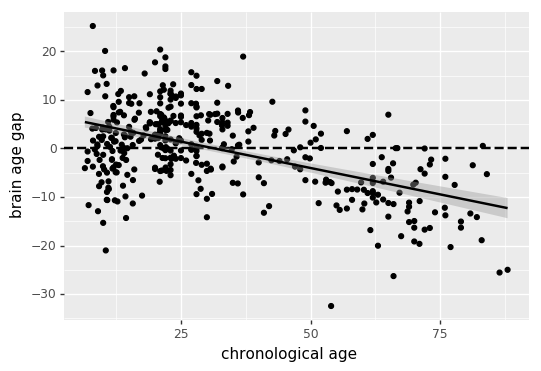

<ggplot: (7552476245)>


In [9]:
# bias shown in brain age gap: over/under-estimate for lower/upper ends
idx = np.argsort(y_test)
age_gap = Y_pred - y_test
dframe = pd.DataFrame()
dframe['age_gap'] = age_gap
dframe['y_test'] = y_test
p1 = ggplot(dframe, aes('y_test','age_gap')) + geom_point() +\
    geom_hline(yintercept=[0], size=1, linetype='--') +\
    xlab('chronological age') +\
    ylab('brain age gap') +\
    stat_smooth(method='lm') 
  
print("[min, median, max] age: [%d %d %d] years" % (min(y_test), np.median(y_test), max(y_test)))
print(p1) 

In [10]:
mean_absolute_error(y_test, Y_pred)

6.773988388847363

In [11]:
corr_test = np.corrcoef(y_test, Y_pred)[0,1]
corr_test

0.9099645198721535

### Gaussian Process Regression

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ExpSineSquared, ConstantKernel as C

In [21]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(0.01) # 5.76
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [22]:
t0 = time.time()
gp.fit(X_train, y_train)
gpr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % gpr_fit)

SVR complexity and bandwidth selected and model fitted in 1231.971 s


In [24]:
Y_pred_gpr, Y_std = gp.predict(X_test, return_std=True)

In [25]:
age_gap_gpr = Y_pred_gpr - y_test

In [33]:
with open('gpr.pickle', 'wb') as f:
    pickle.dump([y_test, age_gap_gpr], f)

[min, median, max] age: [6 25 88] years


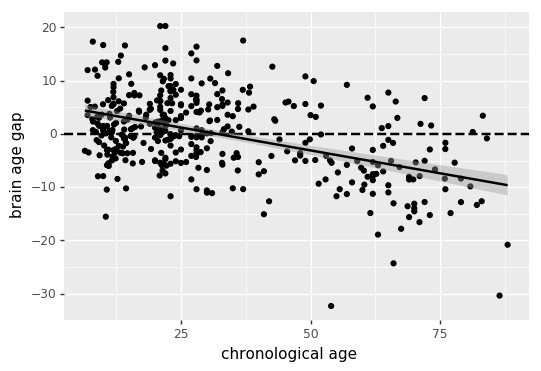

<ggplot: (7574800973)>


In [27]:
# bias shown in brain age gap: over/under-estimate for lower/upper ends
idx = np.argsort(y_test)
age_gap_gpr = Y_pred_gpr - y_test
dframe = pd.DataFrame()
dframe['age_gap_gpr'] = age_gap_gpr
dframe['y_test'] = y_test
p2 = ggplot(dframe, aes('y_test','age_gap_gpr')) + geom_point() +\
    geom_hline(yintercept=[0], size=1, linetype='--') +\
    xlab('chronological age') +\
    ylab('brain age gap') +\
    stat_smooth(method='lm') 
  
print("[min, median, max] age: [%d %d %d] years" % (min(y_test), np.median(y_test), max(y_test)))
print(p2) 

In [36]:
mean_absolute_error(y_test, Y_pred_gpr)

5.959572781212651

In [37]:
corr_test = np.corrcoef(y_test, Y_pred_gpr)[0,1]
corr_test

0.9291503909185668

### Support Vector Regression (SVR)

In [12]:
from __future__ import division
import time

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [13]:
# Fit regression model
seed = 123
np.random.seed(seed)

# svr = GridSearchCV(SVR(kernel='rbf', epsilon=0.1),cv=3,
#                    param_grid={"C": [1e0, 1e1, 1e2, 1e3],
#                                "epsilon": np.logspace(-2, 2, 5)})
svr = GridSearchCV(SVR(kernel='linear', epsilon=0.1),cv=3,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "epsilon": np.logspace(-2, 2, 5)})


In [14]:
t0 = time.time()
svr.fit(X_train, y_train) 
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 588.934 s


In [16]:
Y_pred_svr = svr.predict(X_test)
r_hc = np.corrcoef(y_test.flatten(), Y_pred_svr)
r_hc[1, 0]

0.8869921836656252

In [17]:
mean_absolute_error(y_test, Y_pred_svr)

7.430791553016748

In [18]:
age_gap_svr = Y_pred_svr - y_test

In [19]:
with open('svr.pickle', 'wb') as f:
    pickle.dump([y_test, age_gap_svr], f)

[min, median, max] age: [6 25 88] years


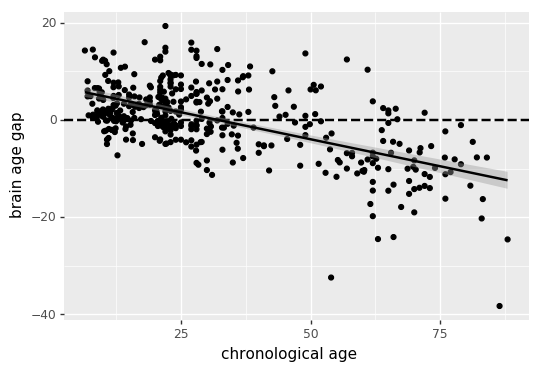

<ggplot: (7547354377)>


In [24]:
# bias shown in brain age gap: over/under-estimate for lower/upper ends
idx = np.argsort(y_test)
age_gap_svr = Y_pred_svr - y_test
dframe = pd.DataFrame()
dframe['age_gap'] = age_gap_svr
dframe['y_test'] = y_test
p3 = ggplot(dframe, aes('y_test','age_gap')) + geom_point() +\
    geom_hline(yintercept=[0], size=1, linetype='--') +\
    xlab('chronological age') +\
    ylab('brain age gap') +\
    stat_smooth(method='lm') 
  
print("[min, median, max] age: [%d %d %d] years" % (min(y_test), np.median(y_test), max(y_test)))
print(p3) 

### Put all outputs in one plot

In [48]:
# Load DNN results
with open('dnn.pickle', 'rb') as f:
    Y_test_dnn, age_gap_dnn = pickle.load(f)

# Load gpr results
with open('gpr.pickle', 'rb') as f:
    y_test, age_gap_gpr = pickle.load(f)

# Load svr results
with open('svr.pickle', 'rb') as f:
    y_test, age_gap_svr = pickle.load(f)

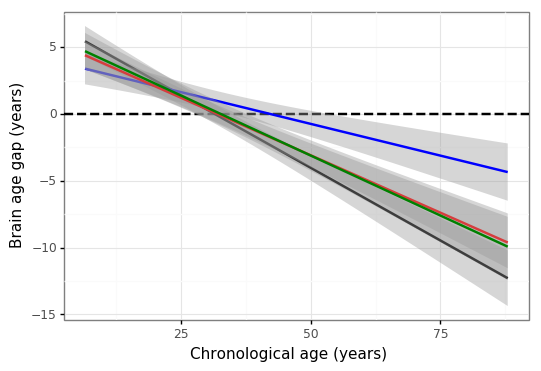

<ggplot: (7541977741)>


In [50]:
# bias shown in brain age gap: over/under-estimate for lower/upper ends
idx = np.argsort(y_test)
age_gap = Y_pred - y_test
dframe = pd.DataFrame()
dframe['age_gap'] = age_gap
dframe['y_test'] = y_test
p1 = ggplot(dframe, aes('y_test','age_gap')) +\
    theme_bw() +\
    geom_hline(yintercept=[0], size=1, linetype='--') +\
    xlab('Chronological age (years)') +\
    ylab('Brain age gap (years)') +\
    stat_smooth(method='lm')
    
# theme_gray()

dframe['age_gap_dnn'] = age_gap_dnn
# dframe['Y_test_dnn'] = Y_test_dnn

p11 = p1 + stat_smooth(aes('y_test','age_gap_dnn'), data = dframe, \
    method='lm', color='blue',size=1) 

dframe['age_gap_gpr'] = age_gap_gpr
p12 = p11 + stat_smooth(aes('y_test','age_gap_gpr'), data = dframe, \
    method='lm', color='red',size=1) 

dframe['age_gap_svr'] = age_gap_svr
p13 = p12 + stat_smooth(aes('y_test','age_gap_svr'), data = dframe, \
    method='lm', color='green',size=1) 

print(p13) 
ggsave(plot = p13, filename = 'RTM_methods.pdf', path = "./full_reduced")


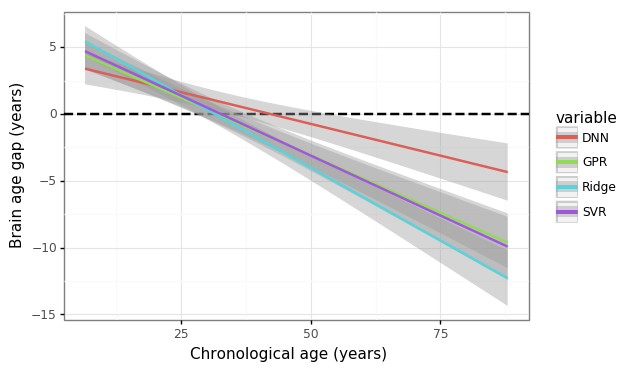

<ggplot: (7543220001)>


In [51]:
df = pd.DataFrame({"y_test": y_test,"Ridge": age_gap, "DNN":age_gap_dnn, \
                   "GPR": age_gap_gpr, "SVR":age_gap_svr})
df2 = pd.melt(df[['y_test','Ridge','DNN','GPR','SVR']],\
              id_vars=['y_test'])
p101 = ggplot(aes(x='y_test', y='value', group='variable', shape='variable', \
           colour='variable'), data=df2) +\
            theme_bw() +\
        geom_hline(yintercept=[0], size=1, linetype='--') +\
        xlab('Chronological age (years)') +\
        ylab('Brain age gap (years)') +\
        stat_smooth(method='lm')

print(p101) 
ggsave(plot = p101, filename = 'RTM_methods.pdf', path = "./full_reduced")
